# <h1> Project 1

# <h2> Gradient - based optimization and differentiable programming

# <h2> Pole - Cart Balancing Controller Design with Neural Network and Gradient Descent.

# <h3> Problem Definition

In this problem, the aim is to design a controller $K$ that makes the open-loop pole cart problem into a closed loop system.
<br/> The controller $K$ helps the pole - cart system to reach desired cart position $r$ and the pole deviation to $0\;degrees$.
<br/> Designing the parameters of $K$ can be tricky and difficult.
<br/> Some common methods of designing the controller are PID and LQR based controllers.
<br/> In this problem, we design controller $K$ using Neural Network and Gradient Descent such that the cart reaches $0.4\;m$ and
the pole stays upright at $0\;degrees$

In [1]:
# Importing Libraries
import logging
import numpy as np
import torch as t
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)

In order to solve the problem, the states needs to be defined accurately. The states chosen are $x = [x\;\dot{x}\;\theta\;\dot{\theta}]$, where
$x$ is the cart position in meters and $\theta$ is the pole deviation from vertical in $rads$. Since, the
states of interest are $x$ and $\theta$ the $C$ matrix is given as:<br/>
$C = \begin{bmatrix}
1&0&0&0\\
0&0&1&0
\end{bmatrix}
$
<br/> The state transition matrix $A$ and control matrix $B$ in discrete states are derived from
continuous state-space model presented by **[UMichigan CTMS](https://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=ControlDigital)**.

In [3]:
# Setting A, B, C and D matrices
A = t.tensor([[1,0.009991,0.0001336,4.453e-07],
             [0,0.9982,0.02672,0.0001336],
             [0,-2.272e-05,1.002,0.01001],
             [0,-0.004544,0.3119,1.002]]).float()
B = t.tensor([[9.086e-05],
              [0.01817],
              [0.0002272],
              [0.04544]]).float()

To create the State Transition loop, we need to understand the control diagram below:
![The San Juan Mountains are beautiful!](/assets/images/Control%20Diagram.PNG "San Juan Mountains")

In [ ]:
# Defining State Transiton Dynamics
class Dynamics(nn.Module):
    def __init__(self):
        super(Dynamics, self).__init__()
    @staticmethod
    def forward(state,k,ref):
        kx = t.tensor([ref]) - t.matmul(k.reshape(1,4),state.reshape(4,1))
        dx = t.matmul(B,kx).reshape(4,1)
        state = t.matmul(A,state.reshape(4,1)) + dx
        return state.reshape(1,4)

In [5]:
# Defining Controller K that is supposed to help the Cart and Pole reach the reference positions
class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input,dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden,dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden,dim_output)
        )

    def forward(self, state):
        k = self.network(state)
        return k

In [6]:
# Define Simulator that calculates new states
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T,ref):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.ref = ref
        self.action_trajectory = []

    def forward(self, state):
        self.state_trajectory = []
        action = self.controller.forward(state)
        for _ in range(T):
            state = self.dynamics.forward(state,action,ref)
            self.state_trajectory.append(state)
        self.action_trajectory.append(action)
        return self.error(state,ref)

    @staticmethod
    def initialize_state():
        state = [0.,0.,0.,0.]
        return t.tensor(state,requires_grad=False).float()
    def error(self,state,ref):
        return (state[0][0]-ref)**2 + state[0][2]**2

In [7]:
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)


    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()


    def train(self, epochs):
        loss_vec = []
        for epoch in range(epochs):
            loss = self.step()
            loss_vec.append(loss)
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            if epoch%5==0:
               self.visualize()
        return loss_vec

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:,0,0]
        y = data[:,0,2]
        fig,ax = plt.subplots()
        ax1 = ax.twinx()
        ax.plot(x,color = 'tab:red',label='Cart')
        ax.set_ylabel('Meters (m)',color = 'tab:red')
        ax.legend()
        ax1.plot(y,color = 'tab:blue',label = 'Pole')
        ax1.set_ylabel('Radians (rad)',color = 'tab:blue')
        ax1.legend()
        plt.title('Step Response')
        plt.show()

[1] loss: 912695.875


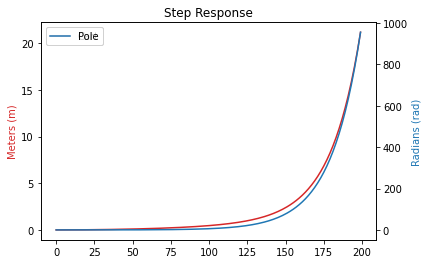

[2] loss: 635037.625
[3] loss: 408822.750
[4] loss: 279417.906
[5] loss: 197353.953
[6] loss: 140862.703


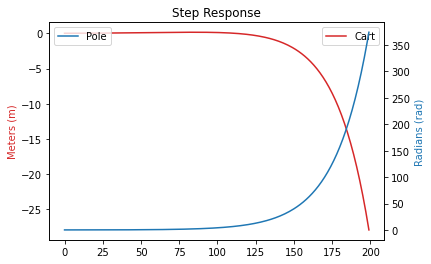

[7] loss: 100516.539
[8] loss: 71437.016
[9] loss: 49376.035
[10] loss: 32488.723
[11] loss: 21950.189


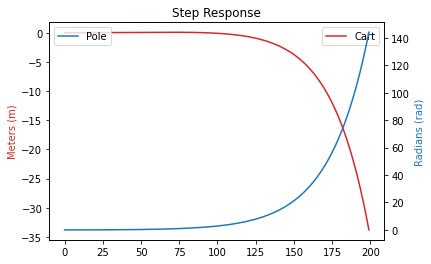

[12] loss: 15391.600
[13] loss: 10456.334
[14] loss: 6632.363
[15] loss: 4544.242
[16] loss: 3274.517


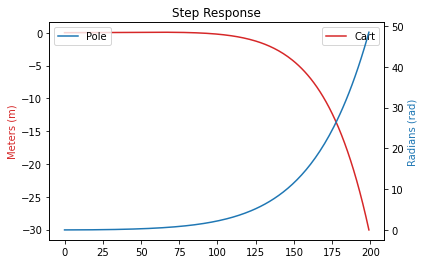

[17] loss: 2409.542
[18] loss: 1758.880
[19] loss: 1325.960
[20] loss: 1054.319
[21] loss: 857.870


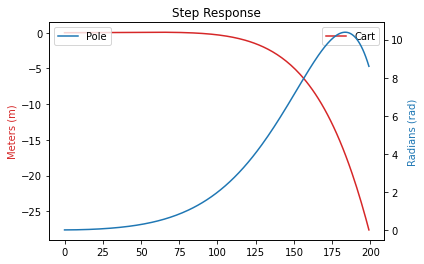

[22] loss: 683.756
[23] loss: 527.547
[24] loss: 401.237
[25] loss: 292.184
[26] loss: 193.601


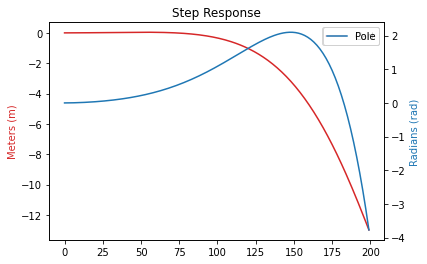

[27] loss: 84.292
[28] loss: 42.103
[29] loss: 24.416
[30] loss: 15.142
[31] loss: 8.732


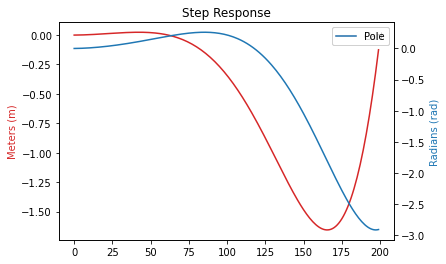

[32] loss: 5.564
[33] loss: 3.598
[34] loss: 2.197
[35] loss: 1.475
[36] loss: 1.039


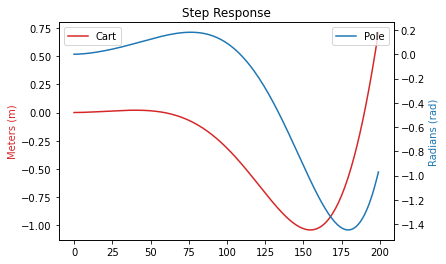

[37] loss: 0.738
[38] loss: 0.512
[39] loss: 0.354
[40] loss: 0.214
[41] loss: 0.111


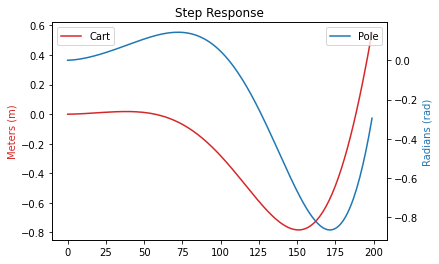

[42] loss: 0.062
[43] loss: 0.032
[44] loss: 0.016
[45] loss: 0.009
[46] loss: 0.005


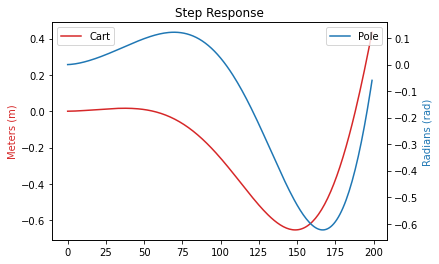

[47] loss: 0.002
[48] loss: 0.001
[49] loss: 0.001
[50] loss: 0.000
[51] loss: 0.000


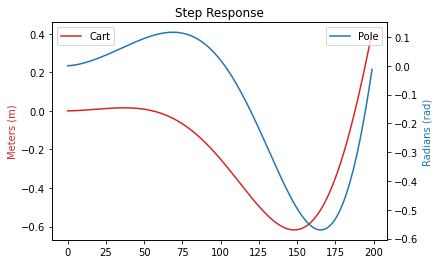

[52] loss: 0.000
[53] loss: 0.000
[54] loss: 0.000
[55] loss: 0.000
[56] loss: 0.000


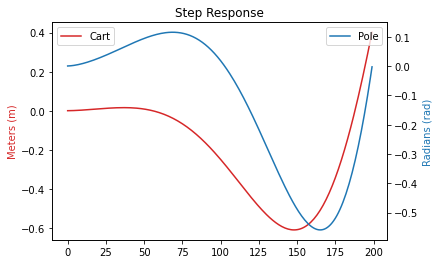

[57] loss: 0.000
[58] loss: 0.000
[59] loss: 0.000
[60] loss: 0.000
[61] loss: 0.000


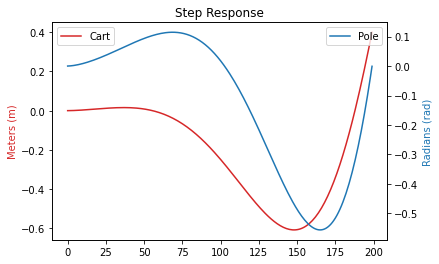

[62] loss: 0.000
[63] loss: 0.000
[64] loss: 0.000
[65] loss: 0.000
[66] loss: 0.000


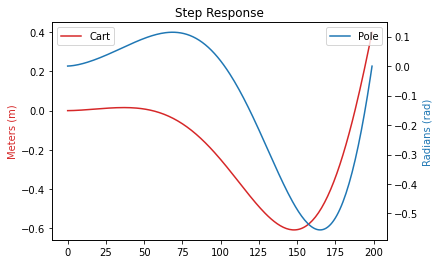

[67] loss: 0.000
[68] loss: 0.000
[69] loss: 0.000
[70] loss: 0.000
[71] loss: 0.000


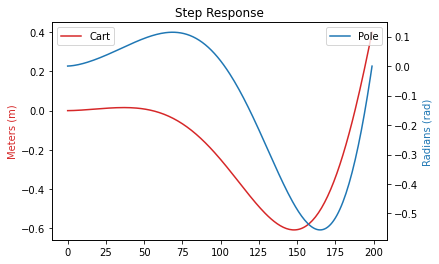

[72] loss: 0.000
[73] loss: 0.000
[74] loss: 0.000
[75] loss: 0.000
[76] loss: 0.000


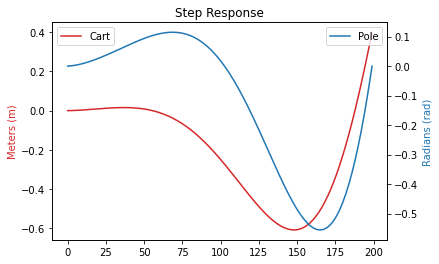

[77] loss: 0.000
[78] loss: 0.000
[79] loss: 0.000
[80] loss: 0.000
[81] loss: 0.000


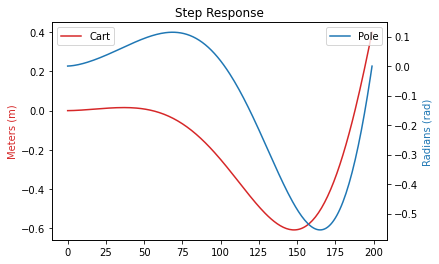

[82] loss: 0.000
[83] loss: 0.000
[84] loss: 0.000
[85] loss: 0.000
[86] loss: 0.000


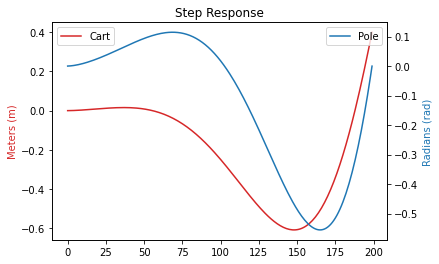

[87] loss: 0.000
[88] loss: 0.000
[89] loss: 0.000
[90] loss: 0.000
[91] loss: 0.000


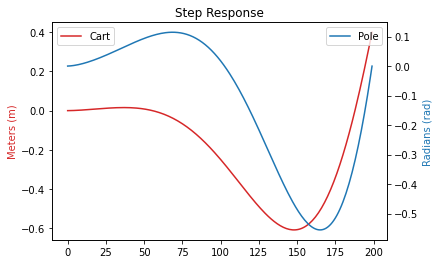

[92] loss: 0.000
[93] loss: 0.000
[94] loss: 0.000
[95] loss: 0.000
[96] loss: 0.000


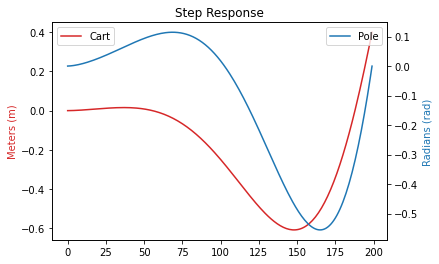

[97] loss: 0.000
[98] loss: 0.000
[99] loss: 0.000
[100] loss: 0.000


In [8]:
dim_input = 4
dim_output = 4
dim_hidden = 10
ref = 0.4
T = 500
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c,d, T,ref)  # define simulation
o = Optimize(s)  # define optimizer
error = o.train(100)

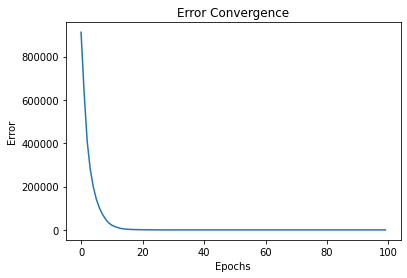

In [29]:
plt.plot(t.tensor(error).detach().numpy())
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.title('Error Convergence')
plt.show()

In [24]:
print('The ideal Controller K = ',s.action_trajectory[-1][:].clone().detach().numpy())

The ideal Controller K =  [-0.0205051 -3.553205   1.542318   3.27144  ]
